# Q-Network Learning: Keras implimentation: DeepMind paper

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

### Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

## The Q-Network Approach

### Implementing the network itself 

In [3]:
def calculate_q(model, s):
    x = np.zeros((1, 16))
    x[0, s] = 1
    return model.predict(x).ravel()
# calculate_q(model, 0)

In [4]:
class CustomLoss(keras.losses.Loss):
    def call(self, y_true, y_pred):
        # print(y_true)
        # print(y_pred)
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.convert_to_tensor(y_true)
        y_true = K.cast(y_true, y_pred.dtype)
        mask = K.cast(y_true > 0, y_pred.dtype)
        dy = y_pred - y_true
        dy = dy * dy * mask
        # dy = dy * dy
        # dy = K.abs(dy) * mask
        return K.sum(dy, axis=-1)


def build_model():
    model = keras.Sequential([
        layers.Dense(4, input_shape=[16], use_bias=False, activation=tf.keras.activations.sigmoid)
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

    model.compile(loss=CustomLoss(),
                  optimizer=optimizer,
                  metrics=None)
    return model

In [5]:
model = build_model()
model.summary()

W0826 15:58:01.778496 140002961893184 deprecation.py:506] From /home/alexey/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 64        
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


### Training the network

In [6]:
# Set learning parameters
y = 0.95
sigma_0 = 0.1
num_episodes = 1000

for n in range(100):
    jList = []
    rList = []
    simulate = []
    sigma = sigma_0 / (n + 1)

    for i in tqdm.tqdm(range(num_episodes)):
        # Reset environment and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j += 1
            # Choose an action by greedily (with e chance of random action) from the Q-network
            q = calculate_q(model, s)
            # TODO: change to beta-distribution
            q += sigma * np.random.randn(*q.shape)
            a = np.argmax(q)
            # Get new state and reward from environment
            s1, r, d, _ = env.step(a)
            q1 = calculate_q(model, s1)
            if d:
                v = r + 1e-6
            else:
                v = r + y * np.max(q1)
            q = np.zeros(q.shape)
            q[a] = v
            simulate.append((s, a, q))
            
            rAll += r
            s = s1
            if d:
                break
        jList.append(j)
        rList.append(rAll)
    print("Percent of succesful episodes: {}%".format(sum(rList) / len(rList) * 100))
    # Trane the data
    x_train = np.zeros((len(simulate), 16))
    y_train = np.zeros((len(simulate), 4))
    for i, x in enumerate(simulate):
        x_train[i, x[0]] = 1
        y_train[i, :] = x[2]
    h = model.fit(x_train, y_train, epochs=10, verbose=0)

100%|██████████| 1000/1000 [00:08<00:00, 112.45it/s]


Percent of succesful episodes: 1.3%


100%|██████████| 1000/1000 [00:16<00:00, 61.14it/s]


Percent of succesful episodes: 4.7%


100%|██████████| 1000/1000 [00:21<00:00, 46.90it/s]


Percent of succesful episodes: 10.100000000000001%


100%|██████████| 1000/1000 [00:34<00:00, 28.91it/s]


Percent of succesful episodes: 24.9%


100%|██████████| 1000/1000 [00:47<00:00, 21.12it/s]


Percent of succesful episodes: 27.0%


100%|██████████| 1000/1000 [00:56<00:00, 14.64it/s]


Percent of succesful episodes: 37.8%


100%|██████████| 1000/1000 [00:56<00:00, 17.83it/s]


Percent of succesful episodes: 33.5%


100%|██████████| 1000/1000 [00:49<00:00, 20.09it/s]


Percent of succesful episodes: 40.0%


100%|██████████| 1000/1000 [00:51<00:00, 19.32it/s]


Percent of succesful episodes: 36.5%


100%|██████████| 1000/1000 [00:47<00:00, 18.70it/s]


Percent of succesful episodes: 41.4%


100%|██████████| 1000/1000 [00:45<00:00, 21.83it/s]


Percent of succesful episodes: 37.0%


100%|██████████| 1000/1000 [00:45<00:00, 21.80it/s]


Percent of succesful episodes: 38.6%


100%|██████████| 1000/1000 [00:44<00:00, 24.19it/s]


Percent of succesful episodes: 42.699999999999996%


100%|██████████| 1000/1000 [00:36<00:00, 27.17it/s]


Percent of succesful episodes: 39.6%


100%|██████████| 1000/1000 [00:33<00:00, 34.88it/s]


Percent of succesful episodes: 35.5%


100%|██████████| 1000/1000 [00:35<00:00, 28.26it/s]


Percent of succesful episodes: 40.1%


100%|██████████| 1000/1000 [00:36<00:00, 27.74it/s]


Percent of succesful episodes: 44.1%


100%|██████████| 1000/1000 [00:35<00:00, 28.31it/s]


Percent of succesful episodes: 44.4%


100%|██████████| 1000/1000 [00:31<00:00, 31.44it/s]


Percent of succesful episodes: 40.1%


100%|██████████| 1000/1000 [00:30<00:00, 32.79it/s]


Percent of succesful episodes: 43.0%


100%|██████████| 1000/1000 [00:35<00:00, 28.24it/s]


Percent of succesful episodes: 47.8%


100%|██████████| 1000/1000 [00:31<00:00, 32.16it/s]


Percent of succesful episodes: 44.4%


100%|██████████| 1000/1000 [00:31<00:00, 31.87it/s]


Percent of succesful episodes: 45.800000000000004%


100%|██████████| 1000/1000 [00:33<00:00, 27.46it/s]


Percent of succesful episodes: 48.6%


100%|██████████| 1000/1000 [00:32<00:00, 31.08it/s]


Percent of succesful episodes: 44.2%


100%|██████████| 1000/1000 [00:33<00:00, 23.69it/s]


Percent of succesful episodes: 49.2%


100%|██████████| 1000/1000 [00:37<00:00, 26.40it/s]


Percent of succesful episodes: 48.3%


100%|██████████| 1000/1000 [00:33<00:00, 29.05it/s]


Percent of succesful episodes: 50.5%


100%|██████████| 1000/1000 [00:35<00:00, 28.50it/s]


Percent of succesful episodes: 52.1%


100%|██████████| 1000/1000 [00:34<00:00, 29.30it/s]


Percent of succesful episodes: 50.2%


100%|██████████| 1000/1000 [00:34<00:00, 29.05it/s]


Percent of succesful episodes: 51.9%


100%|██████████| 1000/1000 [00:38<00:00, 18.69it/s]


Percent of succesful episodes: 52.400000000000006%


100%|██████████| 1000/1000 [00:36<00:00, 27.25it/s]


Percent of succesful episodes: 53.5%


100%|██████████| 1000/1000 [00:34<00:00, 29.35it/s]


Percent of succesful episodes: 53.300000000000004%


100%|██████████| 1000/1000 [00:35<00:00, 33.29it/s]


Percent of succesful episodes: 54.0%


100%|██████████| 1000/1000 [00:35<00:00, 28.37it/s]


Percent of succesful episodes: 54.50000000000001%


100%|██████████| 1000/1000 [00:36<00:00, 27.46it/s]


Percent of succesful episodes: 57.699999999999996%


100%|██████████| 1000/1000 [00:37<00:00, 26.96it/s]


Percent of succesful episodes: 54.2%


100%|██████████| 1000/1000 [00:38<00:00, 26.28it/s]


Percent of succesful episodes: 56.89999999999999%


100%|██████████| 1000/1000 [00:37<00:00, 26.91it/s]


Percent of succesful episodes: 57.099999999999994%


100%|██████████| 1000/1000 [00:36<00:00, 27.24it/s]


Percent of succesful episodes: 57.699999999999996%


100%|██████████| 1000/1000 [00:37<00:00, 27.01it/s]


Percent of succesful episodes: 56.99999999999999%


100%|██████████| 1000/1000 [00:36<00:00, 27.21it/s]


Percent of succesful episodes: 59.8%


100%|██████████| 1000/1000 [00:37<00:00, 26.90it/s]


Percent of succesful episodes: 60.099999999999994%


100%|██████████| 1000/1000 [00:36<00:00, 27.15it/s]


Percent of succesful episodes: 60.3%


100%|██████████| 1000/1000 [00:37<00:00, 26.87it/s]


Percent of succesful episodes: 58.3%


100%|██████████| 1000/1000 [00:37<00:00, 27.83it/s]


Percent of succesful episodes: 57.599999999999994%


100%|██████████| 1000/1000 [00:38<00:00, 25.76it/s]


Percent of succesful episodes: 61.0%


100%|██████████| 1000/1000 [00:41<00:00, 24.39it/s]


Percent of succesful episodes: 61.7%


100%|██████████| 1000/1000 [00:39<00:00, 25.46it/s]


Percent of succesful episodes: 62.5%


100%|██████████| 1000/1000 [00:37<00:00, 26.92it/s]


Percent of succesful episodes: 58.699999999999996%


100%|██████████| 1000/1000 [00:40<00:00, 24.52it/s]


Percent of succesful episodes: 59.8%


100%|██████████| 1000/1000 [00:43<00:00, 23.22it/s]


Percent of succesful episodes: 59.5%


100%|██████████| 1000/1000 [00:40<00:00, 20.20it/s]


Percent of succesful episodes: 60.3%


100%|██████████| 1000/1000 [00:38<00:00, 26.28it/s]


Percent of succesful episodes: 60.3%


100%|██████████| 1000/1000 [00:41<00:00, 24.10it/s]


Percent of succesful episodes: 59.8%


100%|██████████| 1000/1000 [00:40<00:00, 24.81it/s]


Percent of succesful episodes: 62.0%


100%|██████████| 1000/1000 [00:37<00:00, 26.34it/s]


Percent of succesful episodes: 58.9%


100%|██████████| 1000/1000 [00:39<00:00, 25.14it/s]


Percent of succesful episodes: 60.6%


100%|██████████| 1000/1000 [00:38<00:00, 21.84it/s]


Percent of succesful episodes: 60.4%


100%|██████████| 1000/1000 [00:38<00:00, 26.18it/s]


Percent of succesful episodes: 59.699999999999996%


100%|██████████| 1000/1000 [00:40<00:00, 24.51it/s]


Percent of succesful episodes: 59.9%


100%|██████████| 1000/1000 [00:40<00:00, 24.86it/s]


Percent of succesful episodes: 59.9%


100%|██████████| 1000/1000 [00:38<00:00, 25.84it/s]


Percent of succesful episodes: 60.9%


100%|██████████| 1000/1000 [00:52<00:00, 15.47it/s]


Percent of succesful episodes: 61.6%


100%|██████████| 1000/1000 [00:39<00:00, 25.62it/s]


Percent of succesful episodes: 62.8%


100%|██████████| 1000/1000 [00:42<00:00, 24.27it/s]


Percent of succesful episodes: 60.199999999999996%


100%|██████████| 1000/1000 [00:40<00:00, 24.76it/s]


Percent of succesful episodes: 63.1%


100%|██████████| 1000/1000 [00:42<00:00, 23.58it/s]


Percent of succesful episodes: 62.4%


100%|██████████| 1000/1000 [00:41<00:00, 24.22it/s]


Percent of succesful episodes: 63.9%


100%|██████████| 1000/1000 [00:40<00:00, 24.43it/s]


Percent of succesful episodes: 61.1%


100%|██████████| 1000/1000 [00:42<00:00, 27.96it/s]


Percent of succesful episodes: 60.8%


100%|██████████| 1000/1000 [00:42<00:00, 23.52it/s]


Percent of succesful episodes: 62.1%


100%|██████████| 1000/1000 [00:43<00:00, 22.22it/s]


Percent of succesful episodes: 65.3%


100%|██████████| 1000/1000 [00:49<00:00, 20.03it/s]


Percent of succesful episodes: 62.5%


100%|██████████| 1000/1000 [00:46<00:00, 21.34it/s]


Percent of succesful episodes: 62.3%


100%|██████████| 1000/1000 [00:40<00:00, 24.82it/s]


Percent of succesful episodes: 62.4%


100%|██████████| 1000/1000 [00:44<00:00, 22.30it/s]


Percent of succesful episodes: 63.7%


100%|██████████| 1000/1000 [00:39<00:00, 25.17it/s]


Percent of succesful episodes: 64.3%


100%|██████████| 1000/1000 [00:40<00:00, 27.27it/s]


Percent of succesful episodes: 66.0%


100%|██████████| 1000/1000 [00:48<00:00, 20.50it/s]


Percent of succesful episodes: 63.9%


100%|██████████| 1000/1000 [00:39<00:00, 25.36it/s]


Percent of succesful episodes: 64.60000000000001%


100%|██████████| 1000/1000 [00:41<00:00, 24.08it/s]


Percent of succesful episodes: 62.2%


100%|██████████| 1000/1000 [00:41<00:00, 24.29it/s]


Percent of succesful episodes: 63.800000000000004%


100%|██████████| 1000/1000 [00:43<00:00, 18.58it/s]


Percent of succesful episodes: 62.4%


100%|██████████| 1000/1000 [00:40<00:00, 24.42it/s]


Percent of succesful episodes: 64.60000000000001%


100%|██████████| 1000/1000 [00:40<00:00, 24.51it/s]


Percent of succesful episodes: 62.9%


100%|██████████| 1000/1000 [00:41<00:00, 24.25it/s]


Percent of succesful episodes: 60.0%


100%|██████████| 1000/1000 [00:42<00:00, 23.33it/s]


Percent of succesful episodes: 61.8%


100%|██████████| 1000/1000 [00:41<00:00, 24.25it/s]


Percent of succesful episodes: 64.5%


100%|██████████| 1000/1000 [00:43<00:00, 22.24it/s]


Percent of succesful episodes: 62.7%


100%|██████████| 1000/1000 [00:42<00:00, 23.66it/s]


Percent of succesful episodes: 63.1%


100%|██████████| 1000/1000 [00:44<00:00, 28.50it/s]


Percent of succesful episodes: 63.2%


100%|██████████| 1000/1000 [00:39<00:00, 25.09it/s]


Percent of succesful episodes: 63.2%


100%|██████████| 1000/1000 [00:41<00:00, 24.12it/s]


Percent of succesful episodes: 61.5%


100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]


Percent of succesful episodes: 65.8%


100%|██████████| 1000/1000 [00:43<00:00, 23.18it/s]


Percent of succesful episodes: 60.8%


100%|██████████| 1000/1000 [00:42<00:00, 19.09it/s]


Percent of succesful episodes: 64.4%


100%|██████████| 1000/1000 [00:44<00:00, 22.32it/s]


Percent of succesful episodes: 62.9%


100%|██████████| 1000/1000 [00:42<00:00, 23.35it/s]


Percent of succesful episodes: 64.7%


In [8]:
num_episodes = 1000
jList = []
rList = []

for i in tqdm.tqdm(range(num_episodes)):
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    while j < 150:
        j += 1
        q = calculate_q(model, s)
        a = np.argmax(q)
        s1, r, d, _ = env.step(a)
        rAll += r
        s = s1
        if d == True:
            break
    jList.append(j)
    rList.append(rAll)
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes * 100) + "%")

100%|██████████| 1000/1000 [00:21<00:00, 45.73it/s]

Percent of succesful episodes: 64.3%


## Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

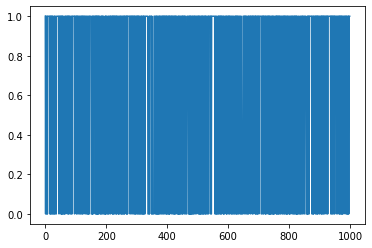

In [9]:
plt.plot(rList)

It also begins to progress through the environment for longer than chance aroudn the 750 mark as well

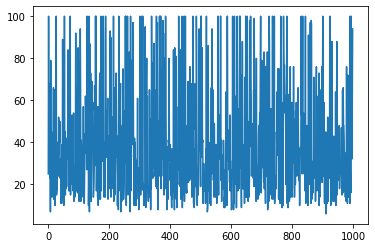

In [10]:
plt.plot(jList)